# Training an CNN to automatically classify storm morphology

### Preprocessing

1) Set the number of classes and size of the image (including the '3rd' dimension, even though these are greyscale)

2) Read in the files using the get_example_data utility

3) Normalize the data by 80 dBZ

4) Verify the shape of the training, validation, and testing datasets

5) Transform the "single number" classifications into keras friendly arrays.

In [1]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
from tensorflow import keras
from tensorflow.keras import layers
import pickle

num_classes = 6
input_shape = (136, 136, 1)

with open("/share/jcorner_data/pkls/1996_2011_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/2012_2013_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/2014_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
gpus

2023-09-11 20:25:35.322198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 20:25:35.329868: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 20:25:35.330040: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Create a simple 3 convolutional and 1 dense layer CNN

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.SpatialDropout2D(0.3),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.6),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 134, 134, 32)      320       
                                                                 
 spatial_dropout2d (SpatialD  (None, 134, 134, 32)     0         
 ropout2D)                                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 44, 44, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 spatial_dropout2d_1 (Spatia  (None, 42, 42, 64)       0         
 lDropout2D)                                                     
                                                        

2023-09-11 20:25:44.484588: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-11 20:25:44.485263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 20:25:44.485465: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-11 20:25:44.485588: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning

In [4]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np


def radar_norm():
    r"""Return a colormap and normalization that allow you to represent
    radar data with colors every 5 dBZ that mimics the official NWS
    radar images.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    norm: BoundaryNorm
        Normalization for 5 dBZ levels (0-80).
    """ 

    cmap = radar_colormap()
    classes = np.array(list(range(0, 85, 5)))
    norm = BoundaryNorm(classes, ncolors=cmap.N)    
    
    return cmap, norm


def radar_colormap():
    r"""Returns an NWS colormap.
    
    Parameters
    ----------
        
    Returns
    -------
    cmap: ListedColormap
        NWS-like radar colormap.
    """ 
 
    nws_reflectivity_colors = ["#ffffff",  # 0
                               "#04e9e7",  # 5
                               "#019ff4",  # 10
                               "#0300f4",  # 15
                               "#02fd02",  # 20
                               "#01c501",  # 25
                               "#008e00",  # 30
                               "#fdf802",  # 35
                               "#e5bc00",  # 40
                               "#fd9500",  # 45
                               "#fd0000",  # 50
                               "#d40000",  # 55
                               "#bc0000",  # 60
                               "#f800fd",  # 65
                               "#9854c6",  # 70
                               "#4B0082",  # 75
                               "#000000"]
                                
    cmap = ListedColormap(nws_reflectivity_colors)
    
    return cmap


def draw_box_plot(ax, img, cbar_shrink=0.35):
    r"""Creates a pre-packaged display for indidivual or summary
    svrimg images.  Modifies an input axis.
    
    Parameters
    ----------
    ax: matplotlib.pyplot.axes.Axes
        Modifiable matplotlib.pyplot axis.
    img: (M, N) ndarray
        SVRIMG radar image
    cbar_shrink: numeric
        Value between 0 - 1.  This will be replacedwith kwargs in 
        future for more customization. Default is 0.35.
    Returns
    -------
    ax: matplotlib.pyplot.axes.Axes
        Modified matplotlib.pyplot axis.
    """ 

    cmap, norm = radar_norm()
    mmp = ax.imshow(np.flipud(img), cmap=cmap, norm=norm)
    ax.arrow(125.5, 119, 0, -0.0001, head_width=10, head_length=15, fc='k', ec='k', zorder=10)
    ax.text(121, 130, "N", fontsize=35, zorder=10)
    
    plt.colorbar(mmp, ax=ax, shrink=cbar_shrink, pad=0.01)
    ax.set_yticks(list(range(0, 153, 17)))
    ax.set_yticklabels([0, 64, 128, 192, 256, 320, 384, 448, 512])
    ax.set_xticks(list(range(0, 153, 17)))
    ax.set_xticklabels([0,  64, 128, 192, 256, 320, 384, 448, 512])
    ax.set_xlabel("km")
    ax.set_ylabel("km")
    ax.grid()
    
    return ax

### Use Data Augmentation to reduce overfitting

We can show how this works with one example. 

<AxesSubplot:xlabel='km', ylabel='km'>

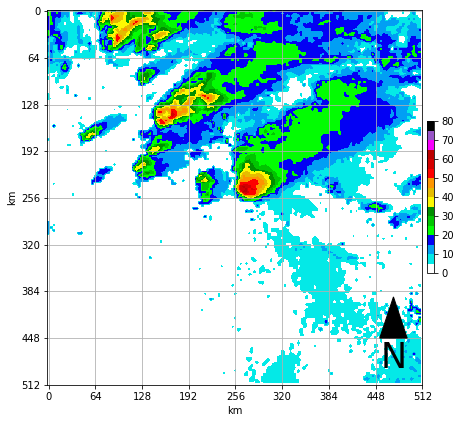

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = 8, 8

from matplotlib.colors import BoundaryNorm

cmap = radar_colormap()
classes = np.array(list(range(0, 85, 5)))
norm = BoundaryNorm(classes, ncolors=cmap.N)

sample = x_test[79]
ax = plt.subplot(1,1,1)
draw_box_plot(ax, sample.squeeze()*80)

We should try to avoid shifting the image left and right, because the location of the 
storm report is right in the middle of each image.  Instead, rotate the image and zoom in and out slightly.
It is also important to ask yourself, does the image augmentation make sense?

We can visualize this with 9 randomly generated examples.

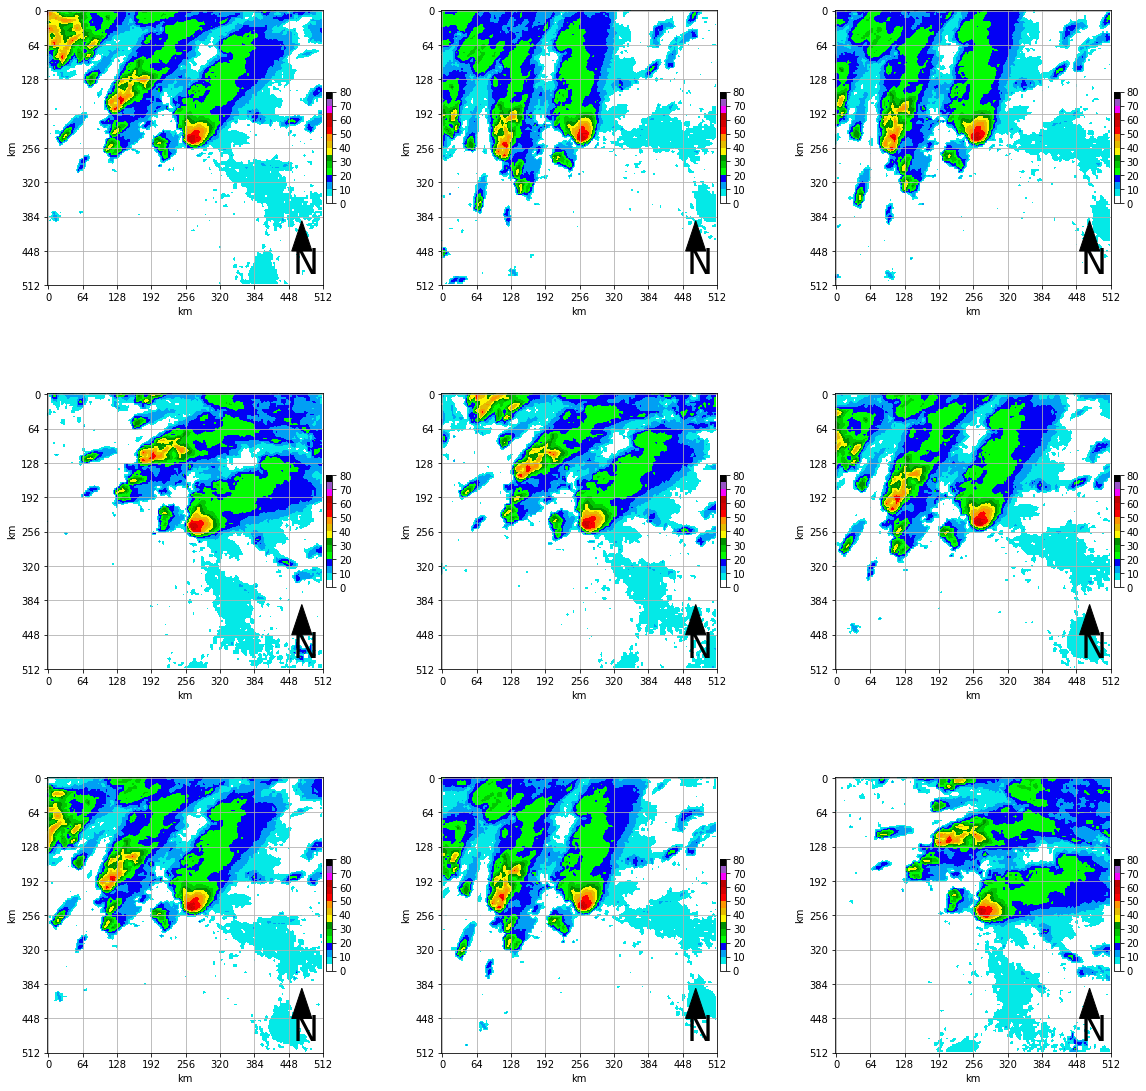

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy import expand_dims

plt.rcParams['figure.figsize'] = 20, 20

samples = expand_dims(sample, 0)

datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

aug_imgs = datagen.flow(samples, batch_size=1)

for i in range(9):
   
    ax = plt.subplot(3,3,i+1)

    batch = aug_imgs.next()

    draw_box_plot(ax, batch[0].squeeze()*80)

Create an image generator for the training data and validation data and pass these values into model.fit().  Wait for the model to finish 100 epochs and test how it did!

Note: modify the "workers" argument depending on what kind of CPU you have.  This was tested on a 20 core machine.

In [16]:
epochs = 40

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                                 epochs=epochs, validation_data=(x_val, y_val), workers=8)

Epoch 1/40
143/143 [==============================] - 7s 46ms/step - loss: 1.3021 - accuracy: 0.4539 - val_loss: 0.8534 - val_accuracy: 0.6408
Epoch 2/40
143/143 [==============================] - 7s 44ms/step - loss: 0.9011 - accuracy: 0.6314 - val_loss: 0.8199 - val_accuracy: 0.6117
Epoch 3/40
143/143 [==============================] - 6s 43ms/step - loss: 0.7624 - accuracy: 0.6947 - val_loss: 0.7366 - val_accuracy: 0.6440
Epoch 4/40
143/143 [==============================] - 6s 43ms/step - loss: 0.6801 - accuracy: 0.7408 - val_loss: 0.3377 - val_accuracy: 0.8803
Epoch 5/40
143/143 [==============================] - 6s 44ms/step - loss: 0.6108 - accuracy: 0.7640 - val_loss: 0.4101 - val_accuracy: 0.8350
Epoch 6/40
143/143 [==============================] - 6s 42ms/step - loss: 0.5540 - accuracy: 0.7805 - val_loss: 0.3572 - val_accuracy: 0.9159
Epoch 7/40
143/143 [==============================] - 6s 42ms/step - loss: 0.5371 - accuracy: 0.7996 - val_loss: 0.3209 - val_accuracy: 0.8738

# Check the change in training and validation accuracy over epochs.

Divergence of these two generally suggests overfitting.  This can be addressed by image augmentation, 
dropout, and getting more data.

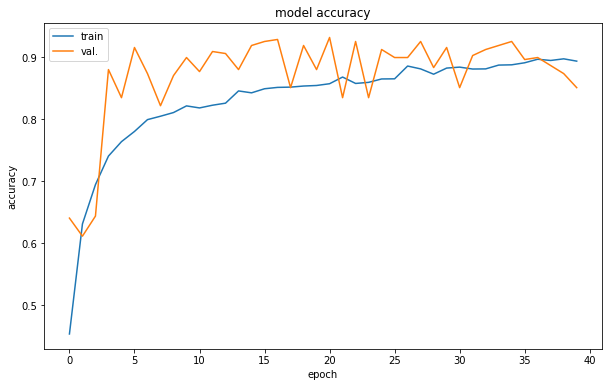

In [17]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

### Check the testing accuracy

If it is similar to the validation accuracy, the model may be generalizing (which is good).

In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.33053264021873474
Test accuracy: 0.883695662021637


2023-08-25 22:23:39.670517: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68065280 exceeds 10% of free system memory.
2023-08-25 22:23:39.723390: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68065280 exceeds 10% of free system memory.


### Check the per class FAR/POD

Add your interpretation here...

In [10]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
y_test_ = np.argmax(y_test, axis=1)

print('Confusion Matrix')
print(confusion_matrix(y_test_, y_pred))
print('Classification Report')
target_names = ['isolated_cell', 'multiple_isolated_cells', 'loosely_clustered_cells', 'tightly_clustered_cells', 'qlcs', 'other']
print(classification_report(y_test_, y_pred, target_names=target_names))

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test_, y_pred), display_labels=target_names)
disp.plot(cmap='Blues')

Confusion Matrix
[[ 39  22   0   0   0   0]
 [  4  75   2   0   0   0]
 [  0  10  63   2   0   0]
 [  0   1   9  54   3   9]
 [  0   0   0   4 469  41]
 [  0   0   0   0   0 113]]
Classification Report
              precision    recall  f1-score   support

    Cellular       0.91      0.64      0.75        61
        QLCS       0.69      0.93      0.79        81
    Tropical       0.85      0.84      0.85        75
       Other       0.90      0.71      0.79        76
     Missing       0.99      0.91      0.95       514
       Noise       0.69      1.00      0.82       113

    accuracy                           0.88       920
   macro avg       0.84      0.84      0.83       920
weighted avg       0.91      0.88      0.89       920



2023-08-25 22:23:46.477722: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68065280 exceeds 10% of free system memory.
2023-08-25 22:23:46.527845: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 68065280 exceeds 10% of free system memory.


### Apply the model to the testing images and compare the predictions to the actual labels

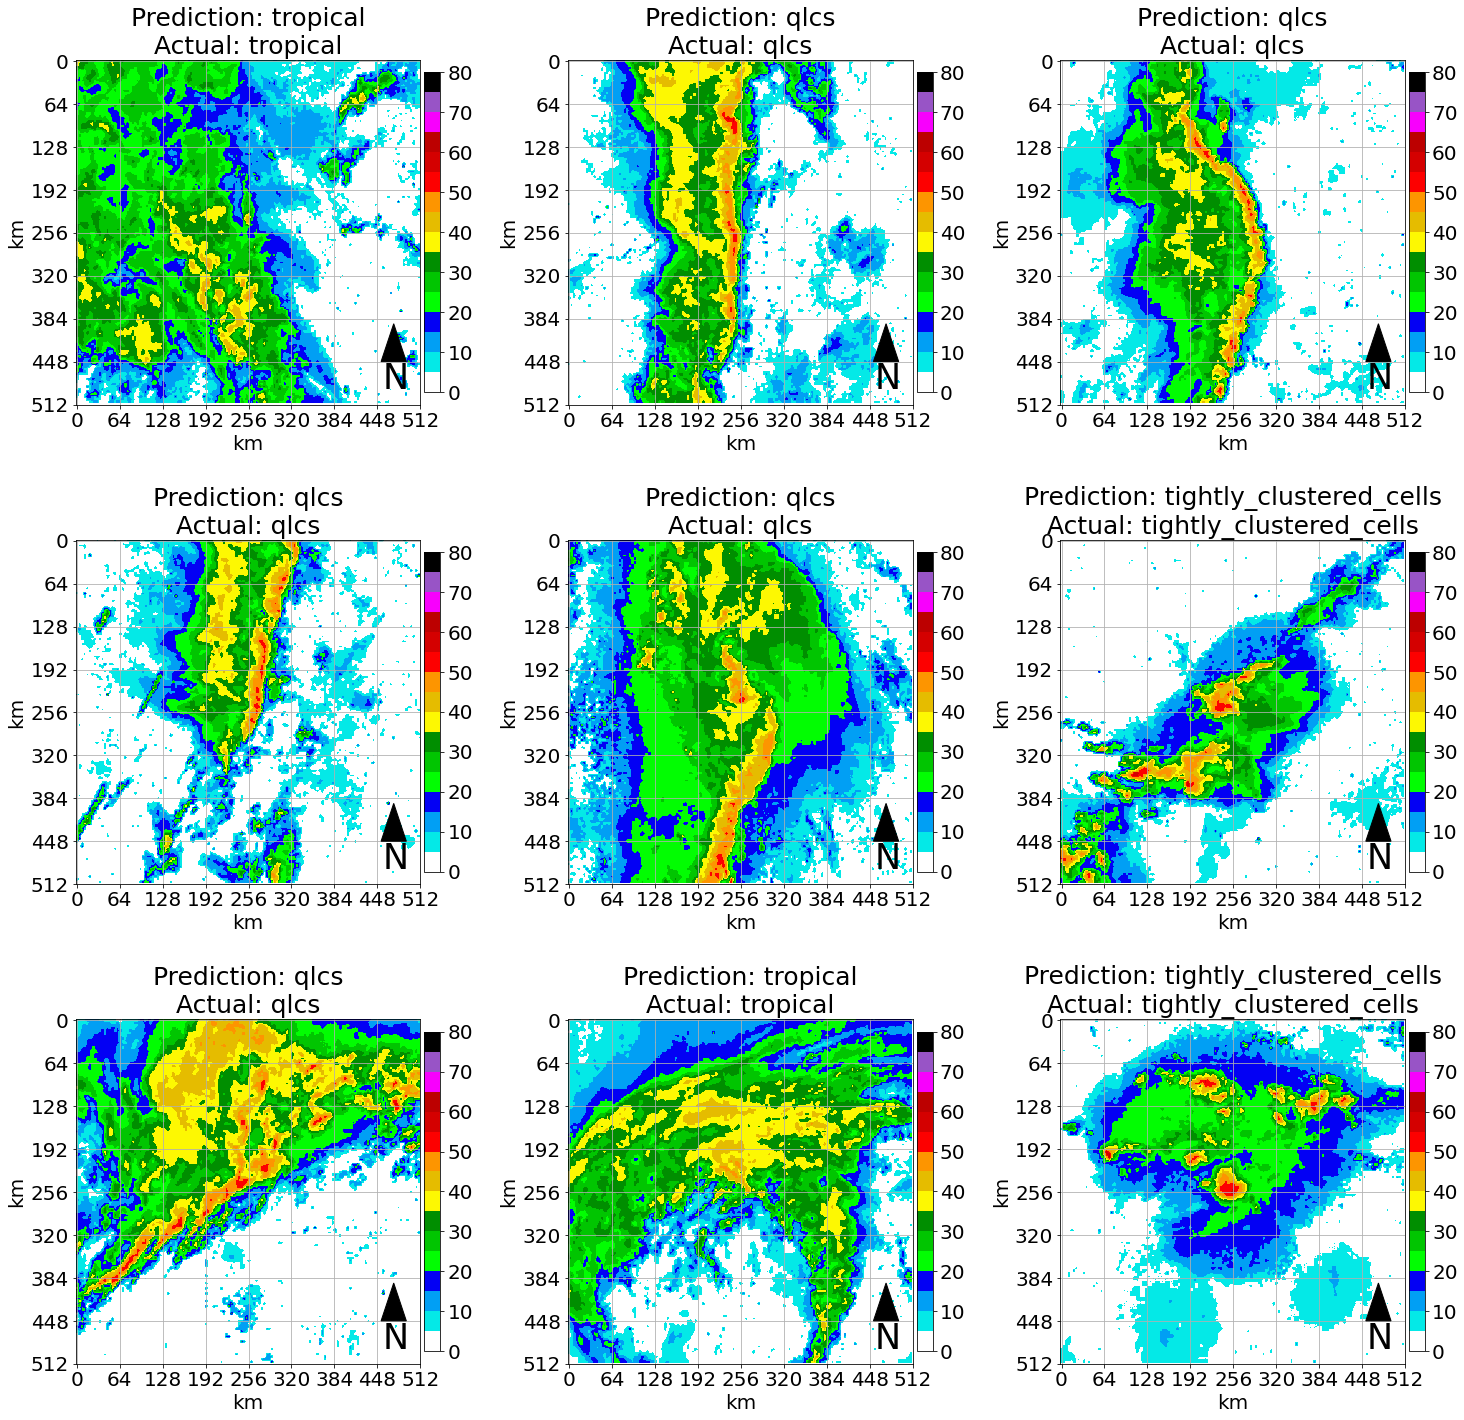

In [20]:
plt.rcParams['figure.figsize'] = 25, 25
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

import pandas as pd
import imageio.v2 as imageio
prefix = "/share/jcorner_data/training_images"

subset = (2014, 2017)
name = "test"

classes = pd.read_csv("/share/jcorner_data/classifications.csv")

classes.head()
    
sample = classes[(classes.yr >= subset[0]) & (classes.yr <= subset[1])].sample(9)
    
image_data = []

for rid, row in sample.iterrows():

    fname = f"{prefix}/{row.yr}/{row.UNID}.png"

    img = imageio.imread(fname, pilmode='P')

    image_data.append(img)
    
imgs = np.expand_dims(np.array(image_data), axis=3) / 80

#Identify the column with the highest probability
pred = np.argmax(model.predict(imgs), axis=1)
truth = sample['Class Code'].values

lookup = {0:'isolated_cell', 1:'multiple_isolated_cells', 
          2:'loosely_clustered_cells', 3:'tightly_clustered_cells', 
          4:'qlcs', 5:'tropical'}

for i, (img, p) in enumerate(zip(imgs, pred)):
    
    ax = plt.subplot(3, 3, i+1)
    
    ax = draw_box_plot(ax, img.squeeze()*80, cbar_shrink=0.8)
    
    ax.set_title("Prediction: {}\nActual: {}".format(lookup[p], lookup[truth[i]]), fontsize=25)



In [19]:
model.save("/share/jcorner_data/models/morph_model_nospace_v04.h5")